# Neural Network Example - 神经网络示例

Build a 2-hidden layers fully connected neural network (a.k.a multilayer perceptron) with TensorFlow v2.

使用 TensorFlow v2 构建一个 2 层隐藏层的全连接神经网络（也称为多层感知器）。

This example is using a low-level approach to better understand all mechanics behind building neural networks and the training process.

这个示例使用了一种低阶的方法来更好地理解构建神经网络和训练过程背后的所有机制。

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## Neural Network Overview - 神经网络一览

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

## MNIST Dataset Overview - MNIST 数据集概述

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 

这个示例使用了 MNIST 手写数字图片数据集。该数据集包含 60000 个用于训练的示例和 10000 个用于测试的示例。这些数字图片的尺寸已经被标准化，以一个固定大小的图像（28x28 像素）并居中，灰度值从 0 到 255。

In this example, each image will be converted to float32, normalized to [0, 1] and flattened to a 1-D array of 784 features (28*28).

在这个示例中，每个图像将被转换为 float32 类型的数组，将其灰度值标准化到 [0, 1] 并展平为一个 784 个特征（28*28）的一维数组。

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [2]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from keras import Model, layers
import numpy as np
import keras._tf_keras.keras.optimizers as optimizers

In [3]:
# MNIST dataset parameters. - MNIST 数据集超参数
num_classes = 10 # total classes (0-9 digits). - 总类别 (数字 0-9 共10类)
num_features = 784 # data features (img shape: 28*28). - 数据特征数 (图像形状: 28*28，共784个像素、即特征)

# Training parameters. - 训练超参数
learning_rate = 0.1 # 学习率
training_steps = 2000 # 训练步数
batch_size = 256 # 批次大小
display_step = 100 # 显示间隔

# Network parameters. - 神经网络相关超参数
n_hidden_1 = 128 # 1st layer number of neurons. - 第一层神经元数量
n_hidden_2 = 256 # 2nd layer number of neurons. - 第二层神经元数量

In [4]:
# Prepare MNIST data. - 加载 MNIST 数据集 以及数据预处理
import keras.api.datasets.mnist as mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32. - 转换为 float32 类型（原先为 uint8 类型，代表0~255的灰度值）
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28). - 将图像展平为 784 特征（28*28）
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1]. - 将图像值从 [0, 255] 标准化为 [0, 1]
x_train, x_test = x_train / 255., x_test / 255.

In [5]:
# Use tf.data API to shuffle and batch data. - 使用 tf.data API 来打乱 并 分批数据
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [6]:
# Create TF Model. - 创建 TensorFlow 模型
class NeuralNet(Model): # 继承 keras.Model 类
    # Set layers. - 初始化层  
    def __init__(self):
        super(NeuralNet, self).__init__() # 调用父类的初始化方法
        # First fully-connected hidden layer. - 第一全连接隐藏层 Dense：全连接层
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.relu) # 指定神经元个数和激活函数
        # First fully-connected hidden layer.  - 第二全连接隐藏层
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.relu)
        # Second fully-connecter hidden layer. - 输出层
        self.out = layers.Dense(num_classes) # 输出层，构造时指定神经元个数为分类的种类数，不指定激活函数

    # Set forward pass. - 前向传播、推理、预测
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        if not is_training: 
            # 译者注: 通常来说, 在训练的时候才需要做 softmax 操作, 因为它可以帮助计算Loss
            # 但是在直接预测的时候, 不需要做 softmax 操作, 只需要 argmax 即可.这里原作者似乎写反了.
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            # 非训练时对模型的输出结果做 softmax 处理
            x = tf.nn.softmax(x)
        return x

# Build neural network model. - 新建神经网络模型对象
neural_net = NeuralNet()

In [7]:
# Cross-Entropy Loss. - 交叉熵误差损失函数
# Note that this will apply 'softmax' to the logits. - 注意这里会对 预测结果 进行 softmax 操作
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function. - 将标签转换为 int64 类型，以便计算交叉熵
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy. - 对 预测结果 应用 softmax 操作并计算交叉熵
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch. - 计算批次的平均损失，这里的 loss 是ndarray，是一个批次的loss，所以有平均值的说法
    return tf.reduce_mean(loss)

# Accuracy metric. - 准确率评估方法
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    # 预测结果是 模型计算结果 中最高分数的索引（即 argmax 函数）
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # 先将上面的布尔数组转换为浮点数数组，然后再计算平均值，即模型的准确率
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer. - 随机梯度下降优化器
optimizer = optimizers.SGD(learning_rate)

In [8]:
# Optimization process. - 优化过程
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    # 使用 tf.GradientTape()管理器记录计算过程，以便自动微分求导
    with tf.GradientTape() as g:
        # Forward pass. - 前向传播、即模型预测
        pred = neural_net(x, is_training=True)
        # Compute loss. - 计算Loss
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables. - 需要更新的变量，即可训练的变量、权重和偏置
    trainable_variables = neural_net.trainable_variables

    # Compute gradients. - 计算梯度
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients. - 根据梯度更新权重和偏置
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [9]:
# Run training for the given number of steps. - 运行给定步数的训练
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1): # 遍历之前创建好的训练数据集
    # Run the optimization to update W and b values. - 运行优化器更新权重和偏置
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0: # 每隔 display_step 步显示一次目前的训练情况，可以明显观察到loss下降的过程
        pred = neural_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y) # 这里的准确率是训练数据集的
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 0.406806, accuracy: 0.894531
step: 200, loss: 0.308143, accuracy: 0.917969
step: 300, loss: 0.260158, accuracy: 0.933594
step: 400, loss: 0.254941, accuracy: 0.941406
step: 500, loss: 0.197532, accuracy: 0.933594
step: 600, loss: 0.182908, accuracy: 0.945312
step: 700, loss: 0.148085, accuracy: 0.964844
step: 800, loss: 0.131899, accuracy: 0.957031
step: 900, loss: 0.152804, accuracy: 0.957031
step: 1000, loss: 0.173485, accuracy: 0.953125
step: 1100, loss: 0.143599, accuracy: 0.957031
step: 1200, loss: 0.078555, accuracy: 0.984375
step: 1300, loss: 0.098070, accuracy: 0.976562
step: 1400, loss: 0.079281, accuracy: 0.976562
step: 1500, loss: 0.096848, accuracy: 0.968750
step: 1600, loss: 0.135379, accuracy: 0.960938
step: 1700, loss: 0.082748, accuracy: 0.976562
step: 1800, loss: 0.092448, accuracy: 0.972656
step: 1900, loss: 0.061917, accuracy: 0.976562
step: 2000, loss: 0.084662, accuracy: 0.980469


In [10]:
# Test model on validation set. - 在测试集上测试模型
pred = neural_net(x_test, is_training=False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.965100


In [11]:
# Visualize predictions. - 数据可视化
import matplotlib.pyplot as plt

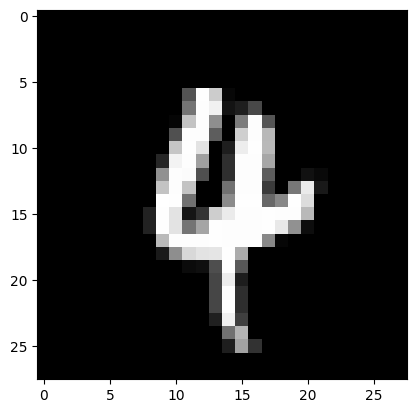

Model prediction: 4


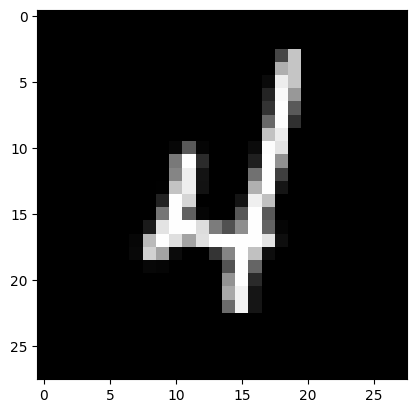

Model prediction: 4


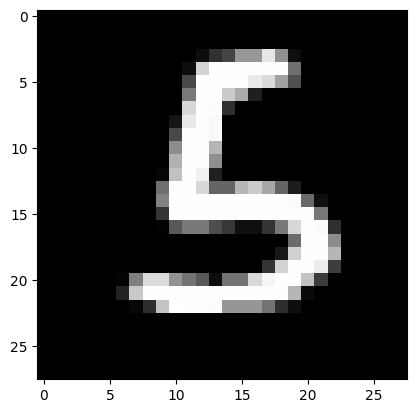

Model prediction: 5


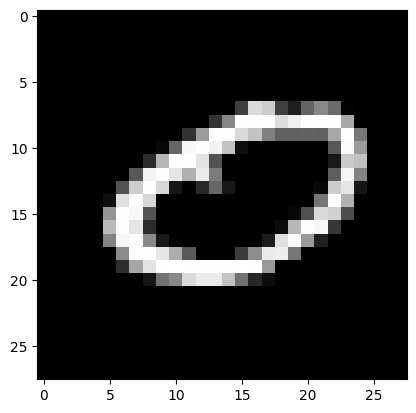

Model prediction: 0


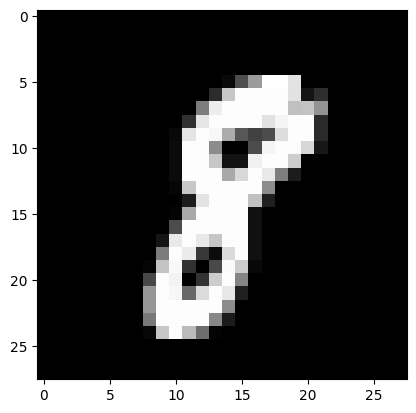

Model prediction: 8


In [14]:
# Predict 5 images from validation set. - 从测试集中随机抽取5张图像预测
n_images = 5
# test_images = x_test[:n_images]
test_images = x_test[np.random.choice(x_test.shape[0], n_images, replace=False)]
predictions = neural_net(test_images)

# Display image and model prediction. - 显示图像和模型预测结果
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))